In [1]:
# 导包
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

In [2]:
@dataclass
class Llama4TextConfig:
    vocab_size: int = 202048  # 词表大小（包含所有token的数量）
    hidden_size: int = 5120  # 隐藏层维度（也即token embedding的维度）
    intermediate_size: int = 8192  # 注意力模块中的中间维度（如用于RMSNorm等）
    intermediate_size_mlp: int = 16384  # MLP模块的中间层维度
    num_hidden_layers: int = 48  # Transformer block 的层数
    num_attention_heads: int = 40  # 注意力头的数量
    num_key_value_heads: int = 8  # KV-head 的数量（可小于attention head数量，表示采用multi-query attention）
    head_dim: int = 128  # 每个注意力头的维度
    max_position_embeddings: int = 4096 * 32  # 最大位置编码长度（支持的最大token序列长度）
    rms_norm_eps: float = 1e-5  # RMSNorm中的epsilon值，防止除以0
    pad_token_id: int = 200018  # padding token 的ID
    bos_token_id: int = 1  # 序列开始（Begin Of Sequence）token 的ID
    eos_token_id: int = 2  # 序列结束（End Of Sequence）token 的ID
    rope_theta: float = 500000  # RoPE位置编码中的 theta 参数（值越大，支持的序列长度越长）
    attention_dropout: float = 0.0  # 注意力模块中的dropout比例（通常在inference时为0）
    num_experts_per_tok: int = 1  # 每个token选中的专家数量（MoE中 Top-K 的K值）
    num_local_experts: int = 16  # 每个MoE层中包含的专家数量
    use_qk_norm: bool = True  # 是否对 QK 做归一化处理（影响注意力权重分布）
    no_rope_layer_interval: int = 4  # 每隔多少层不使用RoPE（控制位置编码插入的层间距）
    attention_chunk_size: int = 8192  # 用于大模型推理时的注意力分块大小（节省显存）
    attn_temperature_tuning: float = 4  # 注意力温度调整因子，用于调节softmax的分布平滑程度
    floor_scale: int = 8192  # 温度缩放的最小尺度（影响softmax的归一化）
    attn_scale: float = 0.1  # 注意力得分的缩放因子，通常用于调节softmax前的qk dot product结果

## 构造MOE模块

### 创建MOE的专家对象

In [3]:
class Llama4TextExperts(nn.Module):

    def __init__(self, config):
        super(Llama4TextExperts, self).__init__()

        # 专家数量
        self.num_experts = config.num_local_experts
        # 前馈全连接中间层维度大小
        self.intermediate_size = config.intermediate_size
        # 隐藏层维度
        self.hidden_size = config.hidden_size
        # 专家维度，与FFN层维度统一
        self.expert_dim = config.intermediate_size

        # 下面三行是MOE的MLP部分，用来实现激活函数前后的线性变换，由于激活函数是将线型变为非线性。
        # gate_up_proj是一个输入数据的加工（专业说法叫上投影层），用nn.Parameter告诉pytorch这是一个可以训练的权重，创建一个没有初始化数值的张量，形状为：[专家数量,隐藏层维度，2倍的专家嵌入维度]
        # 之所以是2倍，因为这一层，我们需要计算两个不同的输出向量：一个是“值（value）”，一个是“门（gate）”。其中gate用于判断，value用于计算。
        self.gate_up_proj = nn.Parameter(torch.empty(self.num_experts, self.hidden_size, 2*self.expert_dim))
        # down_proj是下投影层，用于把上投影层加工的结果变回原始维度的大小，方便后续处理
        self.down_proj = nn.Parameter(torch.empty(self.num_experts, self.expert_dim, self.hidden_size))
        # 一个激活函数，门控结构，用于过滤，让输出更加平滑。也用于线型神经网络变为非线性，能够处理复杂问题
        self.act_fn = nn.SiLU()

        # 对上投影层和下投影层做初始化，使用正态分布。
        nn.init.normal_(self.gate_up_proj)
        nn.init.normal_(self.down_proj)

    def forward(self, hidden_states):

        # 原作者注释：
        ### Hidden States we Pass in Here are already Sorted (according to the logic explained in Llama4TextMoe) ###
        ### Go Ahead and Split the Num Experts and Num Tokens Dimension Up (Num Experts x Num Tokens x Embed Dim) ###

        # 个人注释：
        # 调整数据形状变为：(num_experts, num_tokens, hidden_size)
        hidden_states = hidden_states.reshape(self.num_experts, -1, self.hidden_size)

        #原作者注释：
        ### Now Multiply All our Tokens (copied for each Expert) by each Expert Embeddings ###
        ### gate_up_proj: (Num Experts x Hidden Size x 2*Expert Dim) ###
        ### gate_up -> (Num Experts x Num Tokens x 2*Expert Dim)

        # 使用“数据加工——gate_up_proj” 对当前输入的隐藏层状态进行“加工”，加工方法为批矩阵乘法
        gate_up = torch.bmm(hidden_states, self.gate_up_proj)
        # 原作者注释：
        ### The reason our linear layer was 2*Expert Dim output was because we do a gated linear layer
        ### just like you find in previous Llama implementations
        ### First lets go ahead and chunk on the final dimension so we get two tensors:
        ### gate -> (Num Experts x Num Tokens x Expert Dim)
        ### up -> (Num Experts x Num Tokens x Expert Dim)

        #个人注释：
        # 将gate_up矩阵，在最后一个维度拆分成2份。  之前的 2*self.expert_dim ，现在拆成2等份，每一份最后一个维度为expert_dim。对应gate和value
        gate, up = gate_up.chunk(2, dim=-1)

        # 原作者注释：
        ### Apply the Activation Function to Up (the SiLU activation) and multiply to gate
        ### Effectively giving finer control over what information continues and what doesnt
        ### gated -> (Num Experts x Num Tokens x Expert Dim)

        # 个人注释：
        # 变量gate是门控信息，up里是实际内容。    这里是先将gate信息经过激活函数变为非线性，然后按元素与up中的值做乘法。
        gated = up * self.act_fn(gate)
        # 原作者注释：
        ### Now Finally Projec the Expert Dim back down to the hidden size using Down Proj ###

        #个人注释：
        # 用下投影层将处理过的内容还原，方便后续处理，执行分块矩阵相乘，这样原始数据张量便带有了专家门控信息。
        next_states = torch.bmm(gated, self.down_proj)
        # 原作者注释：
        ### Flatten from (Num Experts x Num Tokens x Embed Dim) -> (Num Experts*Num Tokens x Embed Dim) ###

        #个人注释：
        # 原作者注释写的很清楚，改变最终单个专家输出的形状：(Num Experts x Num Tokens x Embed Dim) -> (Num Experts*Num Tokens x Embed Dim)
        next_states = next_states.view(-1,self.hidden_size)

        return next_states

In [4]:
# LLaMa的共享专家层。减小计算开销，对输入进行统一处理。
# 共享专家负责统一处理所有的输入，执行固定的计算：门控线性变换 -> 上投影 -> 非线性激活 ->下投影
# 共享专家输出的数据形状，与输入是一样的
class Llama4TextMLP(nn.Module):

    def __init__(self, config):

        """
        Exactly the same as the Llama4TextExperts, but this is a single MLP layer. In
        Llama4 they pass tokens to both an MOE and a single MLP and add the results
        """

        super(Llama4TextMLP, self).__init__()

        self.config = config
        self.gate_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.up_proj = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
        self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)
        self.activation_fn = nn.SiLU()

    def forward(self, x):
        gated = self.activation_fn(self.gate_proj(x)) * self.up_proj(x)
        return self.down_proj(gated)

In [5]:
# 构建LLama4的MOE层
class Llama4TextMoe(nn.Module):

    def __init__(self, config):
        super(Llama4TextMoe, self).__init__()

        self.top_k = config.num_experts_per_tok
        self.hidden_dim = config.hidden_size
        self.num_experts = config.num_local_experts
        self.experts = Llama4TextExperts(config)
        self.router = nn.Linear(config.hidden_size, config.num_local_experts, bias=False)
        self.shared_expert = Llama4TextMLP(config)

    def forward(self, hidden_states):
        # [batch_size, seq_len, embed_dim]，比如是 [2, 128, 4096] 表示有两个句子，每个句子 128 个词，每个词用 4096 维的向量表示。
        batch_size, seq_len, embed_dim = hidden_states.shape

        ### Flatten Batch and Seq_Len Dimensions so we have (Num Tokens x Embed Dim) ###
        # 转换数据形状，将输入数据的隐藏层向量变为 ：Num Tokens x Embed Dim
        hidden_states = hidden_states.view(-1, self.hidden_dim)

        ### Get Expert Index for Each Token (Num Tokens x Num Experts) ###
        # 用一个线性层，对输入的隐藏层数据进行打分，确定当前输入的数据更适合哪个“专家”，线性层输出为：专家数量num_local_experts
        router_logits = self.router(hidden_states)    # 路由器选择专家

        ### Now we want each token to go to its own expert, but to parallize this easily we can do the following:
        ### Step 1: Lets pretend each expert will get ALL TOKENS ###
        # 第一步：假设每个专家都会获得所有的token，全部token数tokens_per_expert
        tokens_per_expert = batch_size * seq_len

        ### Step 2: Get the topK experts for each token (from our router logits)
        ### this gives:
        ###     router_top_value: The logit from our router logits sorted for each token from largest to smallest (upto k of them)
        ###     router_indices: The indexes of which expert had the largest logit to smallest (upto k of them)

        # 将路由器输出的结果，即16个专家，选择top_k个进行激活，输出结果为：router_top_value代表最大得分的数值，router_indices最大得分对应的是哪两个专家的索引
        router_top_value, router_indices = torch.topk(router_logits, self.top_k, dim=1)

        ### Step 3: Create a Matrix of -infinity in the shape of (Num Tokens x Num Experts)
        ### Fill this matrix at the indexes of the topk experts selected by the router for each token with the logits for those k experts
        ### Basically makes sure we have -inf for the non topk tokens and its router logit otherwise!
        ### And go ahead and transpose this matrix so it finally becomes as (Num Experts x Num Tokens)

        # 创建一个和router_logits一样大的矩阵，内容填充为负无穷，表示：默认所有专家都不被选中，使用scatter将矩阵中的部分位置，替换成 Top-K 专家的分数。索引为router_indices，值为router_top_value
        # 之后进行一次转置，因为当前是每一列代表一个序列。我们将其转置变为每一行为一个句子序列，代表每个token的专家得分
        router_scores = torch.full_like(router_logits, float("-inf")).scatter_(dim=1, index=router_indices, src=router_top_value).transpose(0,1)

        ### Step 4: Because we are passing in "ALL TOKENS" to every expert, lets update our router indicies to be
        ### indexes from 0 to NUM TOKENS, repeated for EVERY Expert! It will something like:

        ### [0, 1, 2, ..., Num Tokens]
        ### [0, 1, 2, ..., Num Tokens]
        ### [0, 1, 2, ..., Num Tokens]
        ### ...

        ### Repeating the number of rows for the number of experts we have!

        # 首先创建一个一维数组，用来表示每个token的编号，类似于：[0, 1, 2, ..., num_tokens - 1] ，tokens_per_expert = batch_size * seq_len，就是 token 的总数量
        # 把一维数组变为二维：[[0, 1, 2, ..., num_tokens - 1]]
        # 让这个数组复制 num_experts 行.
        # 因为我们下一步要把 hidden_states 中所有 token 的 embedding，复制一份给每个专家。N 个 token，每个专家都要获得这 N 个 token 的编号，用来复制取出数据。

        router_indices = torch.arange(tokens_per_expert, device=hidden_states.device).unsqueeze(0).expand(router_scores.size(0), -1)

        ### Step 5: Now when we grab our embeddings with these indexes, we have the embedding dimension as well. Our Data is the shape
        ### of (Num Tokens x Embed Dim) Lets go ahead and flatten our router indicies, add a dimension for the embed dim and repeat.
        ### This means we will end with a (Num_Experts*Num_tokens x Embed Dim) Matrix at the end.

        # 之前我们拿到二维的token索引矩阵：[num_experts, num_tokens]
        # 现在，每一个 token 的索引，要扩展成 [hidden_dim] 个维度，用来一次性 gather 所有 embedding 维度上的数据
        # 我们需要让 router_indices 的形状变成 [num_experts * num_tokens, hidden_dim]
        router_indices = router_indices.reshape(-1,1).expand(-1, self.hidden_dim)

        ### Step 6: Update our Router Scores to be between 0 and 1. All our non topk scores (that are currently -inf) will become 0!
        # 将router_scores中的值经过sigmoid激活函数，负无穷变为0，其他值变为0~1之间的值，再将张量统一一下浮点数精度。
        router_scores = torch.sigmoid(router_scores.float()).to(hidden_states.dtype)

        ### Step 7: Gather All Our Hidden States By our router_indices (repeating all tokens for each Expert!)

        # gather是一个根据索引去获取值的函数，需要学习一下。在这里，主要是通过index，专家路由器给出的索引，在input（hidden_states）的第一个维度，取数据。
        # 相当于，所有的专家通过这一步才是拿到token的内容。
        routed_in = torch.gather(
            input=hidden_states,
            dim=0,
            index=router_indices
        )

        ### Step 8: We now have repeated all our token embeddings for every expert. But we only want to keep the experts that
        ### were in our TopK. Well, we hav eour router_scores that is 0 for non Topk expert indicies. We can therefore go
        ### ahead and multiply, as it will 0 out our embeddings assigned to a an expert that was not in its TopK
        ### This also multiplies the embeddings from their topk experts by the weights assigned by the router

        ### router_scores -> (Num Experts x Num Tokens)
        ### routed_in -> (Num Experts*Num Tokens x Embed Dim)

        # routed_in形状：[num_experts * num_tokens, hidden_dim]
        # 将router_scores的形状，从[num_experts, num_tokens] 变为 [num_experts * num_tokens, 1]
        # 然后按元素相乘（加权）
        # 最终结果是对routed_in的内容，保留重要的token信息，抑制不重要的信息
        routed_in = routed_in * router_scores.reshape(-1, 1)

        ### Lets Pass this to our Experts!! ###
        ### routed_out -> (Num_Experts*Num_Tokens x Embed Dim)

        # 将处理好的数据，输入进专家。
        # 当routed_in输入进专家模型，发生了什么：self.experts 将根据每个 token 对应的专家模型进行处理。每个专家（专家模型）会处理它接收到的 token 数据，产生一个输出。这些专家是并行的，处理不同 token 数据时具有不同的能力和权重。
        # routed_out 是一个新的 tensor，包含了经过所有专家模型处理后的 token 数据。它的形状通常是 [num_experts * num_tokens, hidden_dim]，和 routed_in 一样，因为每个 token 对应多个专家输出
        routed_out = self.experts(routed_in)

        ### Similary, pass our Hidden States to the Shared Expert ###
        ### In Llama4 we have both Experts and a shared expert ###
        ### and we add the results together at the end! ###
        ### shared_expert_out -> (Num_Tokens x Embed Dim)

        # 经过共享专家MLP层处理
        # 这里hidden_states的形状为：[batch_size * seq_len, hidden_dim]     是将batch_size中所有token合并成一个大的token表。每个token包含embedding信息。
        shared_expert_out = self.shared_expert(hidden_states)

        ### Now we Add our Results Together! But we have a bit of a challenge ###
        ### routed_out repeats all tokens for all experts (but we zeroed out the experts that were not topk for each token)
        ### shared_expert_out is just our projection for all the tokens.
        ### If we want to add our shared_expert_out to our routed_outs, we just need to grab the correct indicies from our
        ### routed_outs that coorespond to the correct experts for each token, and then add it all together!

        ### REMEMBER: The output of Tokens (when passed to their Non-Topk expert) will just be 0!
        ### We are basically going through every experts output here and adding their outputs each expert
        ### to our shared_expert_out. But because there are lots of zeros in our embeddings from each
        ### expert (if that was not a topk expert), we are basically accumulating across all the tokens

        ### This is the same as just for looping through all the expert outputs and adding it to our
        ### shared_expert_out, but this is a oneliner that does that same thing!

        ### Take a look at scatter_add_ if you want more details!
        ### https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_add_.html#torch.Tensor.scatter_add_



        # shared_expert_out -> [num_tokens, hidden_dim]
        # routed_out -> [num_experts * num_tokens, hidden_dim]
        # 我们要把每个专家处理出来的结果（routed_out），累加 到对应的 token 上，也就是 shared_expert_out[token_idx] += routed_out[i]
        # 用for循环是这样写：
        # for i in range(routed_out.size(0)):
        #     idx = router_indices[i]
        #     shared_expert_out[idx] += routed_out[i]

        # 假设每个专家有自己擅长的领域，router会给每个token分配到top_k个专家，每个专家都会返回一个向量（代表每个专家的理解），将这些专家给出的向量结果累加起来，就是输入内容的最终向量表示。
        # 因为每个专家擅长领域不同，并且只选top_k个专家去处理，会漏掉一部分信息，而共享专家会将所有内容进行计算，因此共享专家用来修正top_k个专家给出的结果。因此要加上共享专家输出的结果。
        shared_expert_out.scatter_add_(dim=0, index=router_indices, src=routed_out)

        return shared_expert_out

## 旋转位置编码器

In [6]:
class Llama4TextRotaryEmbedding(nn.Module):

    def __init__(self, config, device=None):
        super(Llama4TextRotaryEmbedding, self).__init__()

        # 保存最大支持的位置长度   KVcache
        self.max_seq_len_cached = config.max_position_embeddings
        # 初始最大序列长度
        self.original_max_seq_len = config.max_position_embeddings

        self.config = config

        # 旋转位置编码器所需要的频率值
        inv_freq = self._compute_default_rope_parameters(self.config, device=device)
        # 将这个频率值注册进模型结构中，而不是作为一个变量。
        self.register_buffer("inv_freq", inv_freq, persistent=False)

    # 计算旋转角频率
    def _compute_default_rope_parameters(self, config, device):

        base = config.rope_theta
        head_dim = config.head_dim


        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2, dtype=torch.int64).to(device=device, dtype=torch.float) / head_dim))

        return inv_freq

    @torch.no_grad()
    def forward(self, x, position_ids):

        ### x is our data (Batch x Seq Len x ) ###
        ### position_ids is the position index of every token (Batch x Seq Len) ###

        ### Our inv_freq is a vector of length (Hidden Dim/2). Lets add dimensions and repeat batch size number of times
        ### inv_freq_expanded -> (Batch x Hidden_Dim/2 x 1)
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1).to(x.device)

        ### Our position ids is just Batch x Seq Len, add a new dimension to make it (Batch x 1 x Seq Len)
        position_ids_expanded = position_ids[:, None, :].float()

        ### Now We can compute our freqs for all positions (by multiplying by the position index) ###
        ### (B x H/2 X 1) @ (B x 1 x L) -> (B x H/2 x L)

        with torch.autocast(device_type=x.device.type, enabled=False):
            # 计算旋转角度（采样频率），广播成(B x H/2 x L)的形状
            freqs = (inv_freq_expanded @ position_ids_expanded)

            ### Now make sure Freqs is (B x L x H/2) by transpose ###
            # 转置成 (B x L x H/2) 的形状
            freqs = freqs.transpose(1,2)

            ### Convert Frequencies to complex (polar) representations (with magnitude 1)###
            # 生成复数形式的旋转位置编码
            freqs_cis = torch.polar(abs=torch.ones_like(freqs), angle=freqs)

        return freqs_cis

In [7]:
# 将复数的旋转位置编码器，注入到q和k张量中
def apply_rotary_emb(xq, xk, freqs_cis):

    ### We want to "rotate" every consecutive pair along the embedding dimension ###
    ### by our freqs_cis, Lets first split them up! ###
    ### xq_split -> (B x Seq_len x Num Heads x Embed_dim/2 x 2)
    ### xk_split -> (B x Seq_len x Num Heads x Embed_dim/2 x 2)

    # 老规矩，将注意力机制的Q和K在最后一个维度进行分成两两一对儿。
    # 假设xq原本为：xq.shape 形状为(2, 3, 4, 8)，对应(batch,seq_len,num_heads,dim)，变成(batch,seq_len,num_heads,dim/2,2)。也就是(2,3,4,4,2)
    # 最后一个维度形状变化：[e0, e1, e2, e3, e4, e5, e6, e7] -> [e0, e1], [e2, e3], [e4, e5], [e6, e7]

    xq_split = xq.float().reshape(*xq.shape[:-1], -1, 2)
    xk_split = xk.float().reshape(*xk.shape[:-1], -1, 2)

    ### Now rotating with a complex number is the same as mulitplying (phase shift) ###
    ### take a look here for rotation property: https://wumbo.net/concepts/complex-number-system/ ###
    ### technically multiplying also scales, but we made sure our freqs_cis was magnitude 1 ###
    ### Problem: xq_split and xk_split are currently real numbers. Lets check what we wanted to do.
    ### Lets go along the embedding dim for one token:
    ### [e0, e1, e2, e3, e4, e5, e6, e7, e8, ...]
    ### We have gone ahead and chunked it like the following:
    ### [e0, e1]
    ### [e2, e3]
    ### [e4, e5]
    ### [e6, e7]
    ### ....

    ### And now we want to rotate each of these 2dim vector by our complex freqs_cis. To do this correctly,
    ### These 2dim vectors must also be complex so we can convert them to complex numbers like the following:
    ### [e0+j*e1]
    ### [e2+j*e3]
    ### [e4+j*e5]
    ### [e6+j*e7]
    ### ....

    ### xq_split -> (B x Seq_len x Num Heads x Embed_dim/2) # Complex number used the 2 dimension from earlier
    ### xk_split -> (B x Seq_len x Num Heads x Embed_dim/2) # Complex number used the 2 dimension from earlier

    # 将q和k转换成复数：[e0 + i·e1], [e2 + i·e3], ...
    xq_split = torch.view_as_complex(xq_split)
    xk_split = torch.view_as_complex(xk_split)

    ### Now Go Ahead and Multiply with our freqs (adding extra dimension for attention heads) !
    # 使用复数乘法，将q和k与之前的旋转位置编码进行按元素计算
    xq_out = xq_split * freqs_cis[:, :, None, :]
    xk_out = xk_split * freqs_cis[:, :, None, :]

    ### Now that we have done our Rotary embeddings with complex numbers, go ahead and return back to real numbers ###
    ### xq_out -> (B x Seq_len x Num Heads x Embed_dim/2 x 2) # Convert to real gave that 2 dimension back
    ### xk_out -> (B x Seq_len x Num Heads x Embed_dim/2 x 2) # Convert to real gave that 2 dimension back

    # 再把复数转换成普通实数。
    xq_out = torch.view_as_real(xq_out)
    xk_out = torch.view_as_real(xk_out)

    ### Flatten Embed_dim/2 x 2 dimensions back to Embed_dim

    # 还原之前的维度变换，也就是 （2，3，4，4，2） -> （2，3，4，8）
    xq_out = xq_out.flatten(3)
    xk_out =xk_out.flatten(3)

    # 输出覆盖了旋转位置编码器的 q和k，并确保数据类型与输入相同。
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [8]:
# 构造一个L2归一化的模块
class Llama4TextL2Norm(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def _norm(self, x):

        ### We want to do x / sqrt((x**2).mean()) along the last dimension! ###
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        return self._norm(x.float()).type_as(x)

    def extra_repr(self):
        return f"eps={self.eps}"

In [9]:
# 构造一个RMSNorm模块，输入为隐藏层维度
class Llama4TextRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):

        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.eps}"

In [10]:
# KV cache层
class Cache:
    """
    KV Cache Method that is close to the Huggingface DynamicCache
    https://github.com/huggingface/transformers/blob/main/src/transformers/cache_utils.py
    """

    def __init__(self, config):

        ### Counter for Number of Tokens in Cache ###
        # 缓存的token数量（计数器）
        self._seen_tokens = 0

        ### Key/Value Cache (List of Tensor, where list is over model layers) ###
        self.key_cache = [torch.tensor([]) for _ in range(config.num_hidden_layers)]
        self.value_cache = [torch.tensor([]) for _ in range(config.num_hidden_layers)]

    def __repr__(self):
        return f"DyanmicCache(Num_Layers: {len(self.key_cache)} | Cached Tokens: {self.key_cache[0].shape[2]})"

    def update(self, key_states, value_states, layer_idx):

        ### Only iterate num tokens seen on the first layer ###
        ### key_states (B x H x L x E)
        ### value_states (B x H x L x E)

        # 形状为：(batch_size, num_heads, seq_len, head_dim)

        if layer_idx == 0:
            # key_states的倒数第二个元素是seq_len
            self._seen_tokens += key_states.shape[-2]

        ### Append New key/Value states to key/value cache ###
        # 将新的key_states和value_chache添加到缓存中。 torch.cat是沿着指定维度进行拼接。  这里是沿着seq_len进行拼接
        self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)
        self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        # 返回更新后的缓存
        return self.key_cache[layer_idx], self.value_cache[layer_idx]

    # 该函数用于返回指定层ID的序列长度（seq_len），如果KVcache为空，则返回0
    def get_seq_len(self, layer_idx=0):
        return self.key_cache[layer_idx].shape[-2] if self.key_cache[layer_idx].numel() != 0 else 0

## LLama4注意力机制实现

In [11]:
a=Llama4TextConfig()
print(dir(a))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'attention_chunk_size', 'attention_dropout', 'attn_scale', 'attn_temperature_tuning', 'bos_token_id', 'eos_token_id', 'floor_scale', 'head_dim', 'hidden_size', 'intermediate_size', 'intermediate_size_mlp', 'max_position_embeddings', 'no_rope_layer_interval', 'num_attention_heads', 'num_experts_per_tok', 'num_hidden_layers', 'num_key_value_heads', 'num_local_experts', 'pad_token_id', 'rms_norm_eps', 'rope_theta', 'use_qk_norm', 'vocab_size']


In [12]:
class Llama4TextAttention(nn.Module):
    def __init__(self, config, layer_idx):
        super(Llama4TextAttention, self).__init__()

        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = config.head_dim
        self.num_attention_heads = config.num_attention_heads
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.scaling = self.head_dim **-0.5
        self.attn_scale = config.attn_scale
        self.floor_scale = config.floor_scale
        self.attn_temperature_tuning = config.attn_temperature_tuning
        self.attention_dropout = config.attention_dropout
        self.is_causal = True
        self.use_rope = int((layer_idx+1) % 4 == 0)

        # 构造QKV的线型投影层。外加一个output的线型投影层
        # 作用：把每个 token 的 hidden state 从维度 hidden_size 映射到 num_attention_heads * head_dim，然后 reshape 为 (B, L, H, D)。
        self.q_proj = nn.Linear(config.hidden_size, config.num_attention_heads*self.head_dim, bias=False)
        # KV层因为共享缓存，因此假设num_key_value_heads为8，而head_dim为128，则K和V的维度为8*128=4096，节约计算成本
        self.k_proj = nn.Linear(config.hidden_size, config.num_key_value_heads*self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, config.num_key_value_heads*self.head_dim, bias=False)
        self.o_proj = nn.Linear(config.num_attention_heads*self.head_dim, config.hidden_size, bias=False)

        if self.config.use_qk_norm and self.use_rope:
            # 对Q和K执行L2归一化
            self.qk_norm = Llama4TextL2Norm()
        else:
            self.qk_norm = None

    def _repeat_kv(self, hidden_states, n_rep):

        ### Add Extra Dimension to Repeat Over ###
        ### (B x H x L x E) -> (B x H x 1 x L x E) -> (B x H x n_rep x L x E) -> (B x H*n_rep x L x E)

        # 因为KV缓存加速计算，而KV的head数量只有8个，而Q使用的num_attention_heads有40个，因此，要对KV进行复制，40//8=5次
        # 获取初始维度
        batch, heads, seq_len, embed_dim = hidden_states.shape
        #  expand: (B, H, n_rep, L, E) → 重复 n_rep 次，但不复制内存
        hidden_states = hidden_states[:, :, None, :, :].expand(batch, heads, n_rep, seq_len, embed_dim)
        # reshape：把 H 和 n_rep 合并，得到 (B, H * n_rep, L, E)
        hidden_states = hidden_states.reshape(batch, heads*n_rep, seq_len, embed_dim)

        return hidden_states

    def forward(self,
                hidden_states,
                position_embeddings=None,
                attention_mask=None,
                past_key_value=None, # this is a Cache Object
                cache_position=None):

        ### Get Shape of Tensor (without Embed dims) ###
        # 提取输入数据的除emb以外的形状
        input_shape = hidden_states.shape[:-1]

        ### Create a Shape Tuple (-1 for num heads in the future) ###
        # 准备将数据变成(batch_size, seq_len, num_heads, head_dim)形状
        hidden_shape = (*input_shape, -1, self.head_dim)

        ### Split Embed Dim by Heads ###
        # 将输入数据拆分成QKV，并且形状与(batch_size, seq_len, num_heads, head_dim)一致
        # 初始为(batch, seq_len, hidden_size)  ->  (batch_size, seq_len, num_heads, head_dim)，其中初始的hidden_size变为num_heads * head_dim
        query_states = self.q_proj(hidden_states).reshape(hidden_shape)
        key_states = self.k_proj(hidden_states).view(hidden_shape)
        # 因为要做Q和K的矩阵乘法，因此要进行转置。
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1,2)

        ### Apply RoPE to Query and Key ###
        # 将旋转位置计算加入进attention
        if self.use_rope:
            query_states, key_states = apply_rotary_emb(query_states, key_states, position_embeddings.to(query_states.device))

        ### L2 Norm ###
        # 对Q和K进行L2归一化
        # 这种方法来源于llama2
        # 归一化后，Attention 得分只依赖于方向（角度），更像是余弦相似度。
        if self.qk_norm is not None:
            query_states = self.qk_norm(query_states)
            key_states = self.qk_norm(key_states)

        ### Temperature Tuning (on layers not using rope) ###
        ### Not total sure how they came up with this as the scaling factor in the ###
        ### Paper they referenced https://arxiv.org/abs/2501.19399
        ### was just S log(N) where S was some learnable parameter

        ### Here was their reasoning:
        ### "We are applying temperature tuning (https://arxiv.org/abs/2501.19399) to NoPE layers, where
        ### the inference-time temperature tuning function is customized to not affect short context
        ### while working at very long context"

        # 对Q的states进行温度调节
        # 可以注意一下这个类的这个属性：self.use_rope = int((layer_idx+1) % 4 == 0) ,根据不同的layer_id，每4层应用一次ROPE。

        # 以下是Nope的部分，即，不使用位置编码器。
        # cache_position 是一个表示位置的张量，用来记录当前处理的 token 在序列中的位置。
        # unsqueeze(0) 是在第一个维度上增加一个新的维度，让它变成二维张量，形状从 [seq_len] 变成 [1, seq_len]
        # expand(hidden_states.shape[0], -1)：将 cache_position 张量在hidden_states的第一个维度进行扩展，即batch_size上进行扩展（重复），-1表示保持其他维度不变。
        cache_position = cache_position.unsqueeze(0).expand(hidden_states.shape[0],-1)
        # 当不使用rope时
        if self.attn_temperature_tuning and not self.use_rope: # 这个参数不明白：attn_temperature_tuning
            # 对于查询向量query_states进行温度调节
            # 首先cache_position的形状是：(batch_size, seq_len)，转换成浮点数加一，相当于下标从1开始，然后除以温度缩放的最小尺度，对结果的每一个元素进行向下取整，结果再加一，乘以注意力缩放因子，再加一
            # 这样得到的attn_scales会根据序列中token的不同位置，来调整注意力缩放因子。
            # 个人觉得，这个地方绝对是一个优化的点。
            attn_scales = (
                torch.log(torch.floor((cache_position.float() + 1.0) / self.floor_scale) + 1.0) * self.attn_scale + 1.0
            )

            # 重塑attn_scales的形状，input_shape的形状为(batch_size, seq_len),转换成：(batch_size, seq_len，1，1)的形状
            # 这样，attn_scales 就可以正确地与 query_states 中的每个 token 进行广播
            attn_scales = attn_scales.view((*input_shape, 1, 1))
            query_states = (query_states * attn_scales).to(query_states.dtype)

        ### Flip the Head and Seq Len Dimensions ###
        ### (B x L x H x D) -> (B x H x L x D)
        # 将Q和K在第二，三维度进行转置，方便后续的计算
        query_states = query_states.transpose(1,2)
        key_states = key_states.transpose(1,2)

        ### Update Key Value Cache ###
        # past_key_value是一个缓存对象，需要更新key的状态向量和v的状态向量，以及神经网络层id
        if past_key_value is not None:
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx)

        ### Grouped Query Attention ###

        ### Step 1: Repeat Keys/Values Heads to match the Query Heads
        ### Query: (B x Attention Heads x L x E)
        ### Key: (B x KV Heads x L x E)
        ### Value: (B x KV Heads x L x E)

        # 将K和V的头数与Q进行对齐，因此需要重复 config.num_attention_heads // config.num_key_value_heads次
        key_states = self._repeat_kv(key_states, self.num_key_value_groups)
        value_states = self._repeat_kv(value_states, self.num_key_value_groups)

        ### Step 2: Compute Attention Weights ###
        # Q和K矩阵做点积，再乘以缩放因子，根号下dk，self.scaling = self.head_dim **-0.5
        attn_weights = torch.matmul(query_states, key_states.transpose(2,3)) * self.scaling

        ### Step 3: Apply Attention Mask (add large negative numbers to masked positions) ###
        ### Also we crop out attention mask only upto the tokens we need ###

        # 注意力机制掩码，此处需要后面传入掩码矩阵
        if attention_mask is not None:

            ### Crop Attetion Mask to only include upto the number of key/value tokens we have to attend to ###
            # key_states.shape[-2] 为seq_len ,在掩码矩阵的最后一个维度，选择序列长度的数值
            causal_mask = attention_mask[:, :, :, :key_states.shape[-2]]

            ### Add Causal Mask to Weights ###
            # 将掩码矩阵和attn矩阵的元素按位置相加
            attn_weights = attn_weights + causal_mask

        ### Standard Attention ###
        # 执行注意力机制后面的计算：经过softmax层，再将结果与V做点积，得到的结果在第二、三维度变回原装，即：(batch_size, seq_len, num_heads, head_dim)
        attn_weights = nn.functional.softmax(attn_weights.float(), dim=-1).to(query_states.dtype)
        attn_output = torch.matmul(attn_weights, value_states)
        attn_output = attn_output.transpose(1,2)

        ### Final Projection ###
        # (batch_size, seq_len, num_heads, head_dim) 转换成为 (batch_size, seq_len, num_heads*head_dim)
        attn_output = attn_output.flatten(2)
        # 输出最终结果之前，经过线型层变换一下，多注意力头合并。
        attn_output = self.o_proj(attn_output)

        return attn_output



In [13]:
a=Llama4TextConfig()
print(dir(a))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'attention_chunk_size', 'attention_dropout', 'attn_scale', 'attn_temperature_tuning', 'bos_token_id', 'eos_token_id', 'floor_scale', 'head_dim', 'hidden_size', 'intermediate_size', 'intermediate_size_mlp', 'max_position_embeddings', 'no_rope_layer_interval', 'num_attention_heads', 'num_experts_per_tok', 'num_hidden_layers', 'num_key_value_heads', 'num_local_experts', 'pad_token_id', 'rms_norm_eps', 'rope_theta', 'use_qk_norm', 'vocab_size']


In [14]:
# 单个llamaBlock实现
class Llama4TextDecoderLayer(nn.Module):

    def __init__(self, config, layer_idx):
        super(Llama4TextDecoderLayer, self).__init__()

        self.layer_idx = layer_idx
        self.hidden_size = config.hidden_size
        self.self_attn = Llama4TextAttention(config, layer_idx)
        self.use_chunked_attention = int((layer_idx+1) % 4 != 0)
        self.feed_forward = Llama4TextMoe(config)
        self.input_layernorm = Llama4TextRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = Llama4TextRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(self,
                hidden_states,
                attention_mask,
                chunk_causal_mask,
                past_key_value,
                cache_position,
                position_embeddings):

        residual = hidden_states

        ### Normalize ###
        # RMSNorm
        hidden_states = self.input_layernorm(hidden_states)

        ### Did you pass in chunked attention mask? Then use it if enabled! ###
        # 是否使用分块注意力机制
        if self.use_chunked_attention and chunk_causal_mask is not None:
            attention_mask = chunk_causal_mask

        ### Compute Attention ###
        # 计算注意力机制
        attention_states = self.self_attn(
                hidden_states=hidden_states,
                position_embeddings=position_embeddings,
                attention_mask=attention_mask,
                past_key_value=past_key_value, # this is a Cache Object
                cache_position=cache_position
        )

        ### Residual Connection ###
        # 将注意力机制计算的结果覆盖到原隐藏层向量矩阵，按元素相加。（残差连接）
        hidden_states = residual + attention_states

        ### MOE Layer ###
        # 用MOE层替换传统的FFN层
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.feed_forward(hidden_states)
        # 残差连接
        hidden_states = residual + hidden_states.view(residual.shape)

        return hidden_states

In [15]:
# 组装Llama的文本模型
class Llama4TextModel(nn.Module):

    def __init__(self, config):
        super(Llama4TextModel, self).__init__()

        self.config = config
        # <PAD> token的id
        self.padding_idx = config.pad_token_id
        # 词表大小
        self.vocab_sie = config.vocab_size

        # 文本token嵌入，把词表中的词映射成固定长度向量
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=self.padding_idx)

        # LlamaBlock的堆叠层数
        self.layers = nn.ModuleList(
            [
                Llama4TextDecoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )
        # 实例化RMS对象
        self.norm = Llama4TextRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        # 实例化旋转位置编码器对象
        self.rotary_emb = Llama4TextRotaryEmbedding(config)

    def forward(self,
                input_ids=None,
                input_embeds=None,
                attention_mask=None,
                position_ids=None,
                past_key_values=None,
                cache_position=None):

        ### Set up Key/Value Cache if it doesnt exist ###
        # KVchche不存在，则创建一个对象
        if past_key_values is None:
            past_key_values = Cache(self.config)

        ### Get Input Embeddings ###
        # 将输入映射成为向量
        if input_embeds is None:
            hidden_states = self.embed_tokens(input_ids)
        else:
            hidden_states = input_embeds

        ### Set up Cache Position ###
        # 如果Nope的位置张量cache_position为空。
        if cache_position is None:
            # past_key_values 是缓存对象，它存储了之前步骤的键值对（key-value pairs）。get_seq_len() 获取缓存中已经处理过的 token 数量，表示已经处理过的序列长度。
            past_seen_tokens = past_key_values.get_seq_len()
            # 生成一个连续的整数序列，表示当前输入中每个 token 在整个序列中的位置
            # 如果之前缓存的token为0，则生成seq_len长度的序列，作为nope的位置表示
            cache_position = torch.arange(past_seen_tokens, past_seen_tokens+hidden_states.shape[1], device=hidden_states.device)

        ### Setup Position Ids ###
        if position_ids is None:
            # cache_position的形状为(seq_len)，需要在第一个维度也就是0维度添加一个维度，变成（batch，seq_len）的形状
            position_ids = cache_position.unsqueeze(0)

        ### Update Causal Mask ###
        # 注意力机制掩码的计算
        causal_mask, chunked_attention_mask = self._update_causal_mask(
            attention_mask, hidden_states, cache_position
        )

        ### Compute Rotary Embeddings ###
        # 旋转位置编码的计算
        freq_cis = self.rotary_emb(hidden_states, position_ids)

        ### Pass Through Layers ###
        # LlamaBlock堆叠组成的model，对于每一个Block，需要将数据经过每一个Vlock前向传播进行计算，得到的隐藏层的向量，传递到下一层。
        for layer in self.layers:
            hidden_states = layer(hidden_states,
                                  attention_mask,
                                  chunked_attention_mask if chunked_attention_mask is not None else causal_mask,
                                  past_key_values,
                                  cache_position,
                                  freq_cis)
        # 当数据经过了所有的Block层，对隐藏层的状态向量进行归一化。
        hidden_states = self.norm(hidden_states)

        # 返回前向传播的结果，以及用于减少计算量的kv缓存，用于下一次迭代不用重复计算。
        return hidden_states, past_key_values


    # 注意力的掩码张量计算包含了两个计算：一个是自回归的因果掩码，一个是分块掩码。
    # 首先是因果掩码
    def _prepare_4d_causal_attention_mask_with_cache_position(
            self,
            attention_mask,
            sequence_length,
            cache_position,
            batch_size,
            dtype,
            device
    ):
        # 如果掩码张量已存在，则直接使用
        if attention_mask is not None:
            causal_mask = attention_mask

        else:

            ### Create a Causal Mask ###
            # torch.finfo(dtype).min是用来获取指定数据类型（dtype）的最小值
            # 如：min_float32=-3.4028235e+38，而min_float64:-1.7976931348623157e+308
            min_dtype = torch.finfo(dtype).min

            # 创建一个形状为(seq*seq)大小的用最小值min_type填充的矩阵
            # 为啥要用极小值？ 因为在做softmax的时候，如果用0填充，则softmax后，e^0 = 1，掩码的部分不会变小，而是获得更多的关注。
            # 而使用极小值，会在经过softmax后，掩码的值更趋近于0
            causal_mask = torch.full(
                (sequence_length, sequence_length), fill_value=min_dtype, dtype=dtype, device=device
            )

            ### If we have more than one token, we need causal mask, so current token doesnt look forward ###
            # 应用因果掩码，右上三角
            if sequence_length != 1:
                causal_mask = torch.triu(causal_mask, diagonal=1)

            ### Check Wherever our Sequence index is longer than the cache positions ###
            ### If a Query is BEFORE the Key/Value Cache Index, then the Query would have ###
            ### to look into the future which is not allowed and needs to be masked! ###

            # 作用，生成一个掩码，保证每个token只能看到自己之前的单词，没办法看到自己之后的单词。
            # 这个代码的思路很有意思，生成seq_len长度的数，与位置缓存中的内容进行比对，返回True或False。
            causal_mask *= torch.arange(sequence_length, device=device) > cache_position.to(device).reshape(-1,1)

            ### Add Extra Dimension to causal Mask (4 dimensions, with placeholder for head dim) ###
            # 将掩码张量添加batch_size，在第一维度，变为(batch_size, 1, sequence_length, sequence_length)
            causal_mask = causal_mask[None, None, :, :].expand(batch_size, 1, -1, -1)

            ### If Attention mask is Not None, then add causal and attention mask together ###
            if attention_mask is not None:
                # 如果attention_mask不为空，则克隆一份作为causal_mask，原始causal_mask不被修改
                causal_mask = causal_mask.clone()

                ### Only keep upto length in attention mask ###
                # 掩码的长度为最后一个维度
                mask_length = attention_mask.shape[-1]
                #causal_mask[:, :, :, :mask_length] 和 attention_mask[:, None, None, :] 进行了加法，生成了一个新的 padding_mask，它包含了 causal_mask 和 attention_mask 合并后的结果。
                padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :].to(device)
                # 生成bool值的掩码，当padding mask中的元素值为0的地方会被设置为True，否则为False
                padding_mask = (padding_mask==0)
                # masked_fill会将padding mask中为True的元素，使用极小值min dtype进行替换
                causal_mask[:,:,:,:mask_length] = causal_mask[:,:,:,:mask_length].masked_fill(padding_mask, min_dtype)

            return causal_mask
    # 创建分块注意力掩码
    def _create_chunked_attention_mask(
            self,
            attention_chunk_size,
            start,
            end,
            device
    ):

        ### Create Blocks in the Chunk Sizes you want ###
        # tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0]])

        # 按照块的大小attention_chunk_size进行创建掩码，创建两个长度相同的矩阵，分别在第1维度和第二维度添加新维度，分别与attention_chunk_size做整除，然后使用abs做两个张量之间差的绝对值
        # 行向量和列向量通过广播机制进行相减，得到的结果为 (end-start)*(end-start)形状的矩阵
        block_pos = torch.abs(
            (torch.arange(start, end).unsqueeze(0)//attention_chunk_size) -
            (torch.arange(start, end).unsqueeze(1)//attention_chunk_size)
        )

        ### Do computation again but without absolute value or division to get token positions###
        # tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        #         [-1,  0,  1,  2,  3,  4,  5,  6,  7],
        #         [-2, -1,  0,  1,  2,  3,  4,  5,  6],
        #         [-3, -2, -1,  0,  1,  2,  3,  4,  5],
        #         [-4, -3, -2, -1,  0,  1,  2,  3,  4],
        #         [-5, -4, -3, -2, -1,  0,  1,  2,  3],
        #         [-6, -5, -4, -3, -2, -1,  0,  1,  2],
        #         [-7, -6, -5, -4, -3, -2, -1,  0,  1],
        #         [-8, -7, -6, -5, -4, -3, -2, -1,  0]])

        #构造一个二维的“位置差值矩阵”，行列相减，广播计算。
        tok_pos = torch.arange(start, end).unsqueeze(0) - torch.arange(start,end).unsqueeze(1)

        ### Wherever our block pos is 0 (our chunks) and our tok_pos is negative (causal mask) We want those ###
        # 上面两个矩阵做运算，最终结果：
        # tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                # [1, 1, 0, 0, 0, 0, 0, 0, 0],
                # [1, 1, 1, 0, 0, 0, 0, 0, 0],
                # [0, 0, 0, 1, 0, 0, 0, 0, 0],
                # [0, 0, 0, 1, 1, 0, 0, 0, 0],
                # [0, 0, 0, 1, 1, 1, 0, 0, 0],
                # [0, 0, 0, 0, 0, 0, 1, 0, 0],
                # [0, 0, 0, 0, 0, 0, 1, 1, 0],
                # [0, 0, 0, 0, 0, 0, 1, 1, 1]])

        mask = (block_pos==0) & (tok_pos<=0)
        # 此处计算，相当于既保留因果掩码，同时也使用分块注意力机制来减少计算量。
        return mask.to(device)

    def _update_causal_mask(self,
                            attention_mask,
                            input_tensor,
                            cache_position):

        ### Get Sequence Length and Attention Chunk Size ###
        ### Honestly the attention chunk size is huge (over 8000)
        ### we could probably skip this as we are just creating a
        ### minimal version here but lets just do it anyway!

        #序列长度
        seq_len = input_tensor.shape[1]
        # 获取分块注意力机制分多少块
        attention_chunk_size = self.config.attention_chunk_size

        ### Get the Starting and Ending Position from Cache ###
        # 从位置信息缓存获取开始的token位置，默认batch_size为1
        start_cache_pos = cache_position[0]

        ### Two Checks: Is our First Cache Position greater than our chunk size:
        # 确认当前是否超过attention_chunk_size，如果超过attention_chunk_size，代表不是第一个注意力掩码的分块，有可能是第二个或者更后面的chunk
        cond1 = start_cache_pos >= attention_chunk_size

        ### Is our first cache in the first chunk, but with the seq_len it rolls over to the second chunk ###
        # 判断当前序列是否跨越了一个 attention chunk 的边界。这个条件的设计在分块注意力中非常关键，用于决定是否要做特殊的 mask 处理。
        #
        cond2 = (start_cache_pos < attention_chunk_size) & (start_cache_pos + seq_len > attention_chunk_size)

        ### This is just a fancy if/else
        ### If cond1 is True then key_length = attention_chunk_size + seq_len - 1
        ### elif cond1 is false, then if cond2 is True then key_length = start_cache_pos + seq_len
        ### else key_length = attention_chunk_size

        # 当cond1 == True，表示整个序列起始位置就在 chunk 边界 之后，即你已经处在 chunk 1、chunk 2 等之后的块中。key 长度设为attention_chunk_size + seq_len - 1，key 范围涵盖前一个 chunk 全部，加上当前序列的长度，-1是为了对其index
        # 当cond1 == False 且 cond2 == True，起始位置在第一个 chunk，但本次序列 跨越 chunk 边界。start_cache_pos + seq_len。表示从起始位置向前看，只允许看到从头到当前序列末尾的所有位置。
        # 当cond1 == False 且 cond2 == False，key的长度为attention_chunk_size，表示 attention mask 只允许关注第一个 chunk 内的 token。
        key_length = torch.where(
            cond1,
            attention_chunk_size + seq_len - 1,
            torch.where(cond2, start_cache_pos + seq_len, attention_chunk_size),
        )

        # 对于短序列，采用完整的因果注意力机制掩码。
        causal_mask = self._prepare_4d_causal_attention_mask_with_cache_position(
            attention_mask,
            sequence_length=seq_len,
            cache_position=cache_position,
            batch_size=input_tensor.shape[0],
            dtype=input_tensor.dtype,
            device=input_tensor.device
        )

        # 对于长序列，使用分块注意力机制掩码，同时需要注意keylength的条件
        chunked_attention_mask = None
        if seq_len > self.config.attention_chunk_size:
            chunked_attention_mask = self._create_chunked_attention_mask(
                self.config.attention_chunk_size,
                start=start_cache_pos,
                end=start_cache_pos+key_length,
                device=input_tensor.device
            )

            ### Mask only valid wherever attention mask is valid ###
            # 避免 padding 位置参与 attention。
            # 即使 chunked 允许 attend 某些位置，如果 attention_mask 说这些是 padding，也强行掩掉。
            chunked_attention_mask = chunked_attention_mask & attention_mask

            ### Add dimensions and fill with -inf ###

            # 最终结果chunked_attention_mask是形状 [1, 1, T_q, T_k]、类型为 float16/32 的张量
            chunked_attention_mask = (
                    # 将 chunked_attention_mask的shape 从 [T_q, T_k] 扩展为 [1, 1, T_q, T_k]
                    chunked_attention_mask[None, None, :, :]
                    .to(input_tensor.dtype)
                    # 掩码填充最小值，如果chunked_attention_mask元素为True则填充float的极小值作为掩码
                    .masked_fill(chunked_attention_mask, torch.finfo(input_tensor.dtype).min)
                )

        return causal_mask, chunked_attention_mask

In [16]:
# 组装Llama4的文本模型
class Llama4ForCausalLM(nn.Module):

    def __init__(self, config):
        super(Llama4ForCausalLM, self).__init__()

        self.model = Llama4TextModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def forward(self,
                input_ids=None,
                input_embeds=None,
                attention_mask=None,
                position_ids=None,
                past_key_values=None):

        outputs, past_key_values = self.model(
            input_ids,
            input_embeds,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values
        )

        logits = self.lm_head(outputs)

        return logits, past_key_values

## 测试一下Llama4的文本模型

In [17]:
config=Llama4TextConfig(hidden_size=768,
                        intermediate_size=768*4,
                        intermediate_size_mlp=768*4,
                        num_hidden_layers=2,
                        num_attention_heads=12,
                        num_key_value_heads=3
                        )
rope=Llama4TextRotaryEmbedding(config)
rand=torch.randn(2,4,768,dtype=torch.float32)
position_ids=torch.arange(0,4).unsqueeze(0).expand(2,-1)
freqs_cis=rope(rand,position_ids)
layer=Llama4TextModel(config)
layer(input_embeds=rand)

(tensor([[[ 0.0025, -0.5620, -0.4375,  ...,  0.0257, -1.3712,  0.6038],
          [-0.4009, -0.6086, -0.9811,  ..., -0.9013, -1.4526, -2.3509],
          [-0.4687, -0.8944, -0.8898,  ..., -0.7189, -0.2462, -1.4411],
          [ 0.1211, -0.0571, -0.7741,  ..., -1.2612,  1.8620, -1.0120]],
 
         [[ 0.2321,  0.9299, -0.7671,  ..., -0.8695, -1.0250, -0.5184],
          [ 0.4672,  2.0185, -0.6713,  ..., -0.0438,  0.4846,  0.7930],
          [ 0.0340, -0.1279,  1.6977,  ...,  1.6885, -0.1599, -0.1174],
          [ 0.4492,  0.1601, -0.9914,  ..., -1.2002, -1.2287, -0.5730]]],
        grad_fn=<MulBackward0>),
 DyanmicCache(Num_Layers: 2 | Cached Tokens: 4))

## Llama4文本部分的训练，保存，以及推理

In [18]:
import urllib.request
# 下载《西游记》文本
url = "https://raw.githubusercontent.com/mc112611/PI-ka-pi/main/xiyouji.txt"
file_name = "xiyouji.txt"
urllib.request.urlretrieve(url, file_name)

('xiyouji.txt', <http.client.HTTPMessage at 0x7dbc2fdba850>)

In [19]:
# 加载文本
with open(file_name, 'r', encoding='utf-8') as f:
    lines = f.read()

# 构建字符表
vocab = sorted(list(set(lines)))
itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

# 编码函数
def encode(s):
    return [stoi[ch] for ch in s]

def decode(indices):
    return ''.join([itos[i] for i in indices])

# 转为 Tensor 数据集
dataset = torch.tensor(encode(lines), dtype=torch.long)


In [20]:
# 修改一下参数，否则太大了

config_test = Llama4TextConfig(
    vocab_size=len(vocab),
    hidden_size=256,
    intermediate_size=512,
    intermediate_size_mlp=512,
    num_hidden_layers=4,
    num_attention_heads=4,
    num_key_value_heads=2,
    head_dim=32,
    max_position_embeddings=128 * 16,
    rms_norm_eps=1e-5,
    pad_token_id=1000,
    bos_token_id=1,
    eos_token_id=2,
    rope_theta=500000,
    attention_dropout=0.0,
    num_experts_per_tok=1,
    num_local_experts=4,
    use_qk_norm=True,
    no_rope_layer_interval=4,
    attention_chunk_size=512,
    attn_temperature_tuning=4,
    floor_scale=8192,
    attn_scale=0.1
)


In [21]:
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import urllib.request
import random
import os

def create_dataloader(dataset, batch_size, context_window, split='train'):
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))

    if split == 'train':
        data = dataset[:train_size]
    elif split == 'val':
        data = dataset[train_size:train_size + val_size]
    else:
        data = dataset[train_size + val_size:]

    print(f"Preparing {split} set with {len(data)} characters...")

    # tqdm 包裹 unfold 显示进度
    data = tqdm(data.unfold(0, context_window, 1), desc="Sliding window")
    data = torch.stack(list(data))
    return DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)


In [22]:
device = torch.device("cpu")

embedding = nn.Embedding(config_test.vocab_size, config_test.hidden_size).to(device)
model = Llama4TextModel(config_test).to(device)
output_head = nn.Linear(config_test.hidden_size, config_test.vocab_size).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(model.parameters()) + list(embedding.parameters()) + list(output_head.parameters()), lr=1e-4
)


## GPU训练

为了使用GPU进行训练，我们需要将KVcache，model，embedding放到显卡上

In [23]:
class Cache:
    """
    KV Cache Method that is close to the Huggingface DynamicCache
    https://github.com/huggingface/transformers/blob/main/src/transformers/cache_utils.py
    """

    def __init__(self, config):
        ### Counter for Number of Tokens in Cache ###
        # 缓存的token数量（计数器）
        self._seen_tokens = 0

        ### Key/Value Cache (List of Tensor, where list is over model layers) ###
        self.key_cache = [torch.tensor([]) for _ in range(config.num_hidden_layers)]
        self.value_cache = [torch.tensor([]) for _ in range(config.num_hidden_layers)]

    def __repr__(self):
        return f"DyanmicCache(Num_Layers: {len(self.key_cache)} | Cached Tokens: {self.key_cache[0].shape[2]})"

    def update(self, key_states, value_states, layer_idx):
        ### Only iterate num tokens seen on the first layer ###
        ### key_states (B x H x L x E)
        ### value_states (B x H x L x E)

        if layer_idx == 0:
            self._seen_tokens += key_states.shape[-2]

        ### Append New key/Value states to key/value cache ###
        self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)
        self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        # 返回更新后的缓存
        return self.key_cache[layer_idx], self.value_cache[layer_idx]

    def get_seq_len(self, layer_idx=0):
        return self.key_cache[layer_idx].shape[-2] if self.key_cache[layer_idx].numel() != 0 else 0

    # 新增：设备迁移方法
    def to(self, device):
        self.key_cache = [key.to(device) for key in self.key_cache]
        self.value_cache = [value.to(device) for value in self.value_cache]
        return self


In [24]:
# 组装Llama的文本模型
class Llama4TextModel(nn.Module):

    def __init__(self, config):
        super(Llama4TextModel, self).__init__()

        self.config = config
        # <PAD> token的id
        self.padding_idx = config.pad_token_id
        # 词表大小
        self.vocab_sie = config.vocab_size

        # 文本token嵌入，把词表中的词映射成固定长度向量
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=self.padding_idx)

        # LlamaBlock的堆叠层数
        self.layers = nn.ModuleList(
            [
                Llama4TextDecoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )
        # 实例化RMS对象
        self.norm = Llama4TextRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        # 实例化旋转位置编码器对象
        self.rotary_emb = Llama4TextRotaryEmbedding(config)

    def forward(self,
                input_ids=None,
                input_embeds=None,
                attention_mask=None,
                position_ids=None,
                past_key_values=None,
                cache_position=None):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        ### Set up Key/Value Cache if it doesnt exist ###
        if past_key_values is None:
            # 确保 KVcache 在相同设备上
            past_key_values = Cache(self.config).to(device)

        ### Get Input Embeddings ###
        if input_embeds is None:
            # 确保 embedding 层输出在相同设备上
            hidden_states = self.embed_tokens(input_ids).to(device)
        else:
            # 确保 input_embeds 在相同设备上
            hidden_states = input_embeds.to(device)

        ### Set up Cache Position ###
        if cache_position is None:
            past_seen_tokens = past_key_values.get_seq_len()
            cache_position = torch.arange(past_seen_tokens, past_seen_tokens+hidden_states.shape[1], device=hidden_states.device)
            # 确保 cache_position 在相同设备上
            cache_position = cache_position.to(device)

        ### Setup Position Ids ###
        # 确保 position_ids 在相同设备上
        if position_ids is None:
            position_ids = cache_position.unsqueeze(0).to(device)

        ### Update Causal Mask ###
        causal_mask, chunked_attention_mask = self._update_causal_mask(
            attention_mask, hidden_states, cache_position
        )

        ### Compute Rotary Embeddings ###
        freq_cis = self.rotary_emb(hidden_states, position_ids)

        ### Pass Through Layers ###
        for layer in self.layers:
            hidden_states = layer(hidden_states,
                                attention_mask,
                                chunked_attention_mask if chunked_attention_mask is not None else causal_mask,
                                past_key_values,
                                cache_position,
                                freq_cis)

        hidden_states = self.norm(hidden_states)

        return hidden_states, past_key_values




    # 注意力的掩码张量计算包含了两个计算：一个是自回归的因果掩码，一个是分块掩码。
    # 首先是因果掩码
    def _prepare_4d_causal_attention_mask_with_cache_position(
            self,
            attention_mask,
            sequence_length,
            cache_position,
            batch_size,
            dtype,
            device
    ):
        # 如果掩码张量已存在，则直接使用
        if attention_mask is not None:
            causal_mask = attention_mask

        else:

            ### Create a Causal Mask ###
            # torch.finfo(dtype).min是用来获取指定数据类型（dtype）的最小值
            # 如：min_float32=-3.4028235e+38，而min_float64:-1.7976931348623157e+308
            min_dtype = torch.finfo(dtype).min

            # 创建一个形状为(seq*seq)大小的用最小值min_type填充的矩阵
            # 为啥要用极小值？ 因为在做softmax的时候，如果用0填充，则softmax后，e^0 = 1，掩码的部分不会变小，而是获得更多的关注。
            # 而使用极小值，会在经过softmax后，掩码的值更趋近于0
            causal_mask = torch.full(
                (sequence_length, sequence_length), fill_value=min_dtype, dtype=dtype, device=device
            )

            ### If we have more than one token, we need causal mask, so current token doesnt look forward ###
            # 应用因果掩码，右上三角
            if sequence_length != 1:
                causal_mask = torch.triu(causal_mask, diagonal=1)

            ### Check Wherever our Sequence index is longer than the cache positions ###
            ### If a Query is BEFORE the Key/Value Cache Index, then the Query would have ###
            ### to look into the future which is not allowed and needs to be masked! ###

            # 作用，生成一个掩码，保证每个token只能看到自己之前的单词，没办法看到自己之后的单词。
            # 这个代码的思路很有意思，生成seq_len长度的数，与位置缓存中的内容进行比对，返回True或False。
            causal_mask *= torch.arange(sequence_length, device=device) > cache_position.to(device).reshape(-1,1)

            ### Add Extra Dimension to causal Mask (4 dimensions, with placeholder for head dim) ###
            # 将掩码张量添加batch_size，在第一维度，变为(batch_size, 1, sequence_length, sequence_length)
            causal_mask = causal_mask[None, None, :, :].expand(batch_size, 1, -1, -1)

            ### If Attention mask is Not None, then add causal and attention mask together ###
            if attention_mask is not None:
                # 如果attention_mask不为空，则克隆一份作为causal_mask，原始causal_mask不被修改
                causal_mask = causal_mask.clone()

                ### Only keep upto length in attention mask ###
                # 掩码的长度为最后一个维度
                mask_length = attention_mask.shape[-1]
                #causal_mask[:, :, :, :mask_length] 和 attention_mask[:, None, None, :] 进行了加法，生成了一个新的 padding_mask，它包含了 causal_mask 和 attention_mask 合并后的结果。
                padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :].to(device)
                # 生成bool值的掩码，当padding mask中的元素值为0的地方会被设置为True，否则为False
                padding_mask = (padding_mask==0)
                # masked_fill会将padding mask中为True的元素，使用极小值min dtype进行替换
                causal_mask[:,:,:,:mask_length] = causal_mask[:,:,:,:mask_length].masked_fill(padding_mask, min_dtype)

            return causal_mask
    # 创建分块注意力掩码
    def _create_chunked_attention_mask(
            self,
            attention_chunk_size,
            start,
            end,
            device
    ):

        ### Create Blocks in the Chunk Sizes you want ###
        # tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [0, 0, 0, 1, 1, 1, 2, 2, 2],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [1, 1, 1, 0, 0, 0, 1, 1, 1],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0],
        #         [2, 2, 2, 1, 1, 1, 0, 0, 0]])

        # 按照块的大小attention_chunk_size进行创建掩码，创建两个长度相同的矩阵，分别在第1维度和第二维度添加新维度，分别与attention_chunk_size做整除，然后使用abs做两个张量之间差的绝对值
        # 行向量和列向量通过广播机制进行相减，得到的结果为 (end-start)*(end-start)形状的矩阵
        block_pos = torch.abs(
            (torch.arange(start, end).unsqueeze(0)//attention_chunk_size) -
            (torch.arange(start, end).unsqueeze(1)//attention_chunk_size)
        )

        ### Do computation again but without absolute value or division to get token positions###
        # tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        #         [-1,  0,  1,  2,  3,  4,  5,  6,  7],
        #         [-2, -1,  0,  1,  2,  3,  4,  5,  6],
        #         [-3, -2, -1,  0,  1,  2,  3,  4,  5],
        #         [-4, -3, -2, -1,  0,  1,  2,  3,  4],
        #         [-5, -4, -3, -2, -1,  0,  1,  2,  3],
        #         [-6, -5, -4, -3, -2, -1,  0,  1,  2],
        #         [-7, -6, -5, -4, -3, -2, -1,  0,  1],
        #         [-8, -7, -6, -5, -4, -3, -2, -1,  0]])

        #构造一个二维的“位置差值矩阵”，行列相减，广播计算。
        tok_pos = torch.arange(start, end).unsqueeze(0) - torch.arange(start,end).unsqueeze(1)

        ### Wherever our block pos is 0 (our chunks) and our tok_pos is negative (causal mask) We want those ###
        # 上面两个矩阵做运算，最终结果：
        # tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                # [1, 1, 0, 0, 0, 0, 0, 0, 0],
                # [1, 1, 1, 0, 0, 0, 0, 0, 0],
                # [0, 0, 0, 1, 0, 0, 0, 0, 0],
                # [0, 0, 0, 1, 1, 0, 0, 0, 0],
                # [0, 0, 0, 1, 1, 1, 0, 0, 0],
                # [0, 0, 0, 0, 0, 0, 1, 0, 0],
                # [0, 0, 0, 0, 0, 0, 1, 1, 0],
                # [0, 0, 0, 0, 0, 0, 1, 1, 1]])

        mask = (block_pos==0) & (tok_pos<=0)
        # 此处计算，相当于既保留因果掩码，同时也使用分块注意力机制来减少计算量。
        return mask.to(device)

    def _update_causal_mask(self,
                            attention_mask,
                            input_tensor,
                            cache_position):

        ### Get Sequence Length and Attention Chunk Size ###
        ### Honestly the attention chunk size is huge (over 8000)
        ### we could probably skip this as we are just creating a
        ### minimal version here but lets just do it anyway!

        #序列长度
        seq_len = input_tensor.shape[1]
        # 获取分块注意力机制分多少块
        attention_chunk_size = self.config.attention_chunk_size

        ### Get the Starting and Ending Position from Cache ###
        # 从位置信息缓存获取开始的token位置，默认batch_size为1
        start_cache_pos = cache_position[0]

        ### Two Checks: Is our First Cache Position greater than our chunk size:
        # 确认当前是否超过attention_chunk_size，如果超过attention_chunk_size，代表不是第一个注意力掩码的分块，有可能是第二个或者更后面的chunk
        cond1 = start_cache_pos >= attention_chunk_size

        ### Is our first cache in the first chunk, but with the seq_len it rolls over to the second chunk ###
        # 判断当前序列是否跨越了一个 attention chunk 的边界。这个条件的设计在分块注意力中非常关键，用于决定是否要做特殊的 mask 处理。
        #
        cond2 = (start_cache_pos < attention_chunk_size) & (start_cache_pos + seq_len > attention_chunk_size)

        ### This is just a fancy if/else
        ### If cond1 is True then key_length = attention_chunk_size + seq_len - 1
        ### elif cond1 is false, then if cond2 is True then key_length = start_cache_pos + seq_len
        ### else key_length = attention_chunk_size

        # 当cond1 == True，表示整个序列起始位置就在 chunk 边界 之后，即你已经处在 chunk 1、chunk 2 等之后的块中。key 长度设为attention_chunk_size + seq_len - 1，key 范围涵盖前一个 chunk 全部，加上当前序列的长度，-1是为了对其index
        # 当cond1 == False 且 cond2 == True，起始位置在第一个 chunk，但本次序列 跨越 chunk 边界。start_cache_pos + seq_len。表示从起始位置向前看，只允许看到从头到当前序列末尾的所有位置。
        # 当cond1 == False 且 cond2 == False，key的长度为attention_chunk_size，表示 attention mask 只允许关注第一个 chunk 内的 token。
        key_length = torch.where(
            cond1,
            attention_chunk_size + seq_len - 1,
            torch.where(cond2, start_cache_pos + seq_len, attention_chunk_size),
        )

        # 对于短序列，采用完整的因果注意力机制掩码。
        causal_mask = self._prepare_4d_causal_attention_mask_with_cache_position(
            attention_mask,
            sequence_length=seq_len,
            cache_position=cache_position,
            batch_size=input_tensor.shape[0],
            dtype=input_tensor.dtype,
            device=input_tensor.device
        )

        # 对于长序列，使用分块注意力机制掩码，同时需要注意keylength的条件
        chunked_attention_mask = None
        if seq_len > self.config.attention_chunk_size:
            chunked_attention_mask = self._create_chunked_attention_mask(
                self.config.attention_chunk_size,
                start=start_cache_pos,
                end=start_cache_pos+key_length,
                device=input_tensor.device
            )

            ### Mask only valid wherever attention mask is valid ###
            # 避免 padding 位置参与 attention。
            # 即使 chunked 允许 attend 某些位置，如果 attention_mask 说这些是 padding，也强行掩掉。
            chunked_attention_mask = chunked_attention_mask & attention_mask

            ### Add dimensions and fill with -inf ###

            # 最终结果chunked_attention_mask是形状 [1, 1, T_q, T_k]、类型为 float16/32 的张量
            chunked_attention_mask = (
                    # 将 chunked_attention_mask的shape 从 [T_q, T_k] 扩展为 [1, 1, T_q, T_k]
                    chunked_attention_mask[None, None, :, :]
                    .to(input_tensor.dtype)
                    # 掩码填充最小值，如果chunked_attention_mask元素为True则填充float的极小值作为掩码
                    .masked_fill(chunked_attention_mask, torch.finfo(input_tensor.dtype).min)
                )

        return causal_mask, chunked_attention_mask

Using device: cuda
Preparing train set with 526638 characters...


Sliding window:   0%|          | 0/526511 [00:00<?, ?it/s]


 Epoch 1/1


Training:   0%|          | 0/4114 [00:00<?, ?it/s]

✅ Epoch 1 finished | 🔺 Average Loss: 4.2095


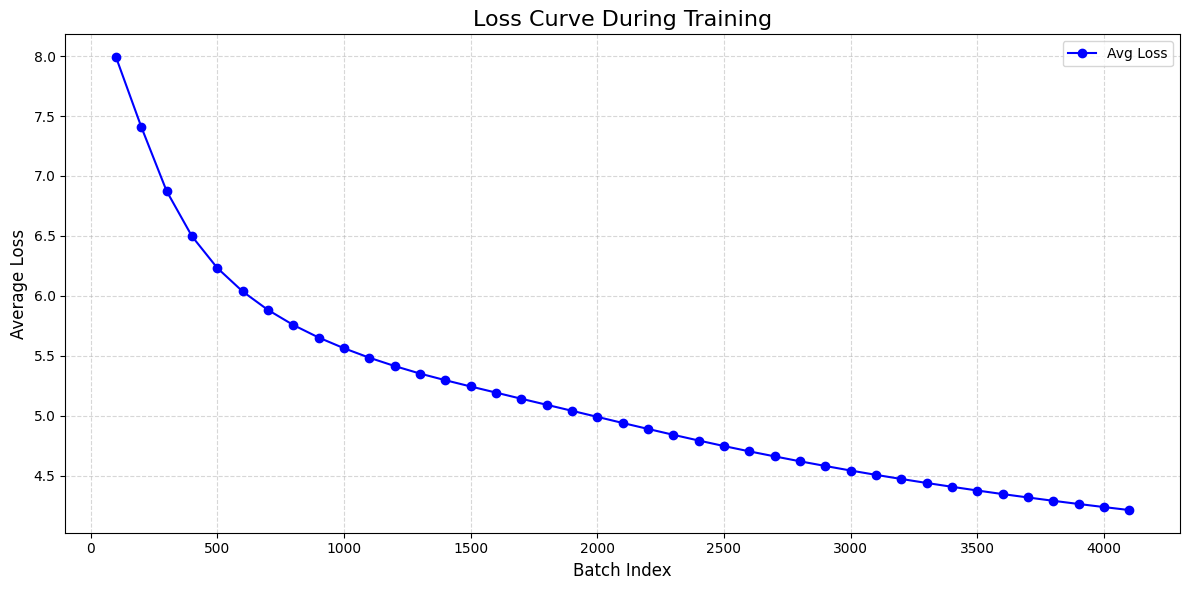

In [29]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 初始化模型组件
embedding = nn.Embedding(config_test.vocab_size, config_test.hidden_size).to(device)
model = Llama4TextModel(config_test).to(device)
output_head = nn.Linear(config_test.hidden_size, config_test.vocab_size).to(device)

# 损失函数与优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(model.parameters()) + list(embedding.parameters()) + list(output_head.parameters()),
    lr=1e-4
)

# 超参数
epochs = 1
batch_size = 128
context_window = 128
log_every = 100  # 每 log_every 个 batch 记录一次损失

train_loader = create_dataloader(dataset, batch_size, context_window, split='train')

# 存储每次记录时的 batch 编号和对应的 loss
logged_batches = []
logged_losses = []

# ==== 训练循环 ====
for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (inputs,) in enumerate(progress_bar):
        inputs = inputs.long().to(device)
        targets = inputs[:, 1:].contiguous()
        inputs = inputs[:, :-1].contiguous()

        input_embeds = embedding(inputs)

        optimizer.zero_grad()
        outputs = model(input_embeds=input_embeds)
        hidden_states = outputs[0]
        logits = output_head(hidden_states)

        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 控制记录频率
        if (batch_idx + 1) % log_every == 0:
            avg_batch_loss = total_loss / (batch_idx + 1)
            logged_batches.append(batch_idx + 1)
            logged_losses.append(avg_batch_loss)

        # tqdm 实时更新
        progress_bar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Avg Loss": f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} finished | 🔺 Average Loss: {avg_loss:.4f}")

# ==== 绘图 ====
plt.figure(figsize=(12, 6))
plt.plot(logged_batches, logged_losses, marker='o', linestyle='-', color='blue', label='Avg Loss')
plt.title('Loss Curve During Training', fontsize=16)
plt.xlabel('Batch Index', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('loss_curve_smooth.png')
plt.show()


In [26]:
save_path = "./llama4text_model.pth"
torch.save({
    "model_state": model.state_dict(),
    "embedding_state": embedding.state_dict(),
    "output_head_state": output_head.state_dict(),
    "vocab": vocab,
    "config": config_test.__dict__
}, save_path)
print("模型已保存！")


模型已保存！


In [27]:
print("正在加载模型权重...")
checkpoint = torch.load("llama4text_model.pth", map_location=device)

vocab = checkpoint['vocab']
itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

config_test_generate = Llama4TextConfig(**checkpoint["config"])
embedding = nn.Embedding(config_test_generate.vocab_size, config_test_generate.hidden_size).to(device)
model = Llama4TextModel(config_test_generate).to(device)
output_head = nn.Linear(config_test_generate.hidden_size, config_test_generate.vocab_size).to(device)

embedding.load_state_dict(checkpoint['embedding_state'])
model.load_state_dict(checkpoint['model_state'])
output_head.load_state_dict(checkpoint['output_head_state'])

print("模型加载完毕咯")


🔄 正在加载模型权重...
✅ 模型加载完毕


In [32]:
import torch.nn.functional as F
from IPython.display import display, Markdown

def sample_next_token(logits, top_k=10, top_p=0.9, temperature=1.0):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)

    # Top-k 筛选
    if top_k is not None:
        top_k = min(top_k, probs.size(-1))
        values, indices = torch.topk(probs, top_k)
        probs_zero = torch.zeros_like(probs).scatter(-1, indices, values)
        probs = probs_zero / probs_zero.sum()

    # Top-p 筛选
    if top_p is not None:
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        cutoff = cumulative_probs > top_p
        if torch.any(cutoff):
            last_index = torch.where(cutoff)[0][0] + 1
            sorted_probs = sorted_probs[:last_index]
            sorted_indices = sorted_indices[:last_index]
        probs = torch.zeros_like(probs).scatter(-1, sorted_indices, sorted_probs)
        probs = probs / probs.sum()

    return torch.multinomial(probs, num_samples=1).item()

def generate_text(start_text='', length=200, top_k=10, top_p=0.9, temperature=1.0):
    if not start_text:
        start_text = random.choice(vocab)
    print(f"🌱 初始字符: {start_text}")

    input_ids = torch.tensor([stoi[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)

    for _ in tqdm(range(length), desc="Generating"):
        input_embeds = embedding(input_ids)
        with torch.no_grad():
            outputs = model(input_embeds=input_embeds)
        hidden_states = outputs[0]
        logits = output_head(hidden_states[:, -1, :])  # 只取最后一个 token 的 logits

        next_id = sample_next_token(logits.squeeze(), top_k=top_k, top_p=top_p, temperature=temperature)
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

    generated = decode(input_ids[0].tolist())
    return generated


generated = generate_text(length=100, top_k=3, top_p=0.9, temperature=1.7)
display(Markdown(generated))


🌱 初始字符: 蛋


Generating:   0%|          | 0/100 [00:00<?, ?it/s]

蛋产森罗刹内观看经偈王、五五百岁经文牒咒》径直裰门外公主婚阳峪杀—————————————————————————————————————————————————————————————————————